In [2]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
import statsmodels as sm
import lr

# read file

In [282]:
file_sofa = pd.read_csv("pn_virus/full_vpn.csv",index_col=0)

In [287]:
keep_var = ["subject_id",
"hadm_id",
"stay_id",
"gender",
"ventilation_status",
"Congestive heart failure",
"Cardiacarrhythmias",
"Pulmonarycirculation",
"Hypertention",
"Chronicpulmonary",
"Renal failure",
"Diabetes",
"los",
"death_day",
"30day_death"]
cont_var = ["age",
            "weight",
            "respiration_24hours",
            "coagulation_24hours",
            "liver_24hours",
            "cardiovascular_24hours",
            "cns_24hours",
            "renal_24hours",
            "sofa_24hours",
            # "hemoglobin_min",
            # "hemoglobin_max",
            # "platelets_min",
            # "wbc_max",
            # "abs_basophils_max",
            # "abs_eosinophils_max",
            # "abs_lymphocytes_max",
            # "abs_monocytes_max",
            # "abs_neutrophils_max",
            # "imm_granulocytes_max",
            # "glucose_min",
            # "glucose_max",
            # "aniongap_max",
            # "bicarbonate_min",
            # "bicarbonate_max",
            # "calcium_min",
            # "calcium_max",
            # "chloride_min",
            # "chloride_max",
            # "sodium_min",
            # "sodium_max",
            # "potassium_min",
            # "potassium_max",
            # "bun_min",
            # "bun_max",
            # "d_dimer_max",
            # "fibrinogen_max",
            # "inr_max",
            # "pt_max",
            # "ptt_max",
            # "albumin_min",
            # "alt_max",
            # "alp_max",
            # "ast_max",
            # "amylase_max",
            # "bilirubin_total_max",
            # "bilirubin_direct_max",
            # "bilirubin_indirect_max",
            # "ck_cpk_max",
            # "ck_mb_max",
            # "ggt_max",
            # "ld_ldh_max",
            # "crp"
            ]
dis_var = [
    "gender",
    "ventilation_status",
    "Congestive heart failure",
    "Cardiacarrhythmias",
    "Pulmonarycirculation",
    "Hypertention",
    "Chronicpulmonary",
    "Renal failure",
    "Diabetes",]

In [288]:
file_sofa = file_sofa[keep_var+cont_var]
file_sofa.loc[file_sofa["ventilation_status"]>0,"ventilation_status"] = 1

In [305]:
# cont_file = convert_var(file_sofa, 
#                         keep_var,
#                         cont_var,
#                         [])
cont_file = file_sofa
code_pn = pd.read_csv("pn_virus/code_vpn.csv",index_col=0,header=0)
nfile = lr.convert_var(code_pn,
                    ["subject_id",
                    "hadm_id",
                    "stay_id"],
                    [],
                    dis_var=["long_title"])
code_pn = nfile.groupby(["subject_id","hadm_id","stay_id"]).agg(sum).reset_index()
dis_var.extend(code_pn.columns[3:])

file_nsofa = pd.merge(cont_file, code_pn, "outer")
for i in dis_var:
    file_nsofa.loc[file_nsofa[i].isnull(), i] = 0

In [296]:
np.sum(file_nsofa.isnull())

subject_id                                           0
hadm_id                                              0
stay_id                                              0
gender                                               0
ventilation_status                                   0
Congestive heart failure                             0
Cardiacarrhythmias                                   0
Pulmonarycirculation                                 0
Hypertention                                         0
Chronicpulmonary                                     0
Renal failure                                        0
Diabetes                                             0
los                                                  0
death_day                                            0
30day_death                                          0
age                                                  0
weight                                               0
respiration_24hours                                  0
coagulatio

# 单因素

In [297]:
from scipy import stats
dic = {}
for i in cont_var:
    subs = file_nsofa.loc[file_nsofa["30day_death"]==0,i]
    subd = file_nsofa.loc[file_nsofa["30day_death"]==1,i]
    dic[i] = [
        "%.1f(%.1f,%.1f)" % (
                np.mean(subs), 
                np.mean(subs)-np.std(subs),
                np.mean(subs)+np.std(subs)),
        "%.1f(%.1f,%.1f)" % (
                np.mean(subd), 
                np.mean(subd)-np.std(subd),
                np.mean(subd)+np.std(subd)),
          "%.2f" % (stats.mannwhitneyu(subs.T, subd.T,alternative='two-sided').pvalue)]
    
for i in dis_var:
  
    subs = file_nsofa.loc[file_nsofa["30day_death"]==0,i]
    subd = file_nsofa.loc[file_nsofa["30day_death"]==1,i]
    
    a = np.sum(subs)
    b = subs.shape[0] - np.sum(subs)
    c = np.sum(subd)
    d = subd.shape[0] - np.sum(subd)
    
    tab = [[a,b],[c,d]]
    if (a+b+c+d > 40)  & (min([a,b,c,d]) > 5):
      p = "%.2f" % (stats.chi2_contingency(tab,correction=False)[1])
    if (a+b+c+d > 40)  & (min([a,b,c,d]) < 5) & (min([a,b,c,d]) > 1):
      p = "%.2f" % (stats.chi2_contingency(tab,correction=True)[1])
    if (a+b+c+d < 40)  or (min([a,b,c,d]) < 1):
      p = "%.2f" % (stats.fisher_exact(tab)[1])
    dic[i] = ["%s/%s(%.2f)" % (a, a+b, a/(a+b)*100),
          "%s/%s(%.2f)" % (c, c+d, c/(c+d)*100),
          p]

In [298]:
pd.DataFrame(dic).T

,0,1,2
age,"65.5(47.3,83.7)","69.2(53.9,84.5)",0.30
weight,"82.7(59.7,105.7)","76.2(51.7,100.8)",0.02
respiration_24hours,"0.7(-0.4,1.8)","1.8(0.3,3.4)",0.00
coagulation_24hours,"0.6(-0.3,1.4)","1.0(-0.2,2.2)",0.00
liver_24hours,"0.1(-0.3,0.5)","0.6(-0.4,1.5)",0.00
cardiovascular_24hours,"0.6(-0.5,1.7)","1.2(-0.3,2.8)",0.00
cns_24hours,"0.2(-0.4,0.8)","0.4(-0.3,1.1)",0.03
renal_24hours,"0.6(-0.4,1.7)","1.1(-0.0,2.3)",0.00
sofa_24hours,"2.8(0.5,5.1)","6.2(2.9,9.5)",0.00
gender,204/409(49.88),22/54(40.74),0.21


# 多因素

In [ ]:
file_nsofa.columns = ['subject_id', 'hadm_id', 'stay_id', 
    'gender', 
    'ventilation_status',
    'Congestiveheartfailure', 
    'Cardiacarrhythmias',
    'Pulmonarycirculation', 
    'Hypertention', 
    'Chronicpulmonary',
    'Renalfailure', 
    'Diabetes', 

    'los', 'death_day', 'death', 
    'age',
    'weight', 
    'respiration_24hours', 
    'coagulation_24hours', 
    'liver_24hours',
    'cardiovascular_24hours', 
    'cns_24hours', 
    'renal_24hours',
    'sofa_24hours', 
    'anaerobes',
    'escherichiacoli',
    'hemophilusinfluenzae',
    'klebsiellapneumoniae',
    'legionnairesdisease',
    'methicillinresistantstaphylococcusaureus',
    'methicillinsusceptiblestaphylococcusaureus',
    'mycoplasmapneumoniae',
    'othergramnegativebacteria',
    'otherspecifiedbacteria',
    'otherstaphylococcus',
    'otherstreptococcus', 
    'pseudomonas',
    'unspecifiedbacteria']
convar = '+'.join([
    'age',
    'weight', 
    'respiration_24hours', 
    'coagulation_24hours', 
    'liver_24hours',
    'cardiovascular_24hours', 
    'cns_24hours', 
    'renal_24hours',
    'sofa_24hours', 
    'anaerobes',
    'escherichiacoli',
    'hemophilusinfluenzae',
    'klebsiellapneumoniae',
    'legionnairesdisease',
    'methicillinresistantstaphylococcusaureus',
    'methicillinsusceptiblestaphylococcusaureus',
    'mycoplasmapneumoniae',
    'othergramnegativebacteria',
    'otherspecifiedbacteria',
    'otherstaphylococcus',
    'otherstreptococcus', 
    'pseudomonas',
    'unspecifiedbacteria'])
disvar = "C("+')+C('.join(['gender', 
    'ventilation_status',
    'Congestiveheartfailure', 
    'Cardiacarrhythmias',
    'Pulmonarycirculation', 
    'Hypertention', 
    'Chronicpulmonary',
    'Renalfailure', 
    'Diabetes'])+ ")"

In [299]:
file_nsofa.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'gender', 'ventilation_status',
       'Congestive heart failure', 'Cardiacarrhythmias',
       'Pulmonarycirculation', 'Hypertention', 'Chronicpulmonary',
       'Renal failure', 'Diabetes', 'los', 'death_day', '30day_death', 'age',
       'weight', 'respiration_24hours', 'coagulation_24hours', 'liver_24hours',
       'cardiovascular_24hours', 'cns_24hours', 'renal_24hours',
       'sofa_24hours', 'influenza due to identified avian influenza virus',
       'influenza due to identified h1n1 influenza virus',
       'influenza due to influenza', 'pneumonia due to adenovirus',
       'pneumonia due to human metapneumovirus pneumonia',
       'pneumonia due to other virus', 'pneumonia due to parainfluenza virus',
       'pneumonia due to respiratory syncytial virus'],
      dtype='object')

In [300]:
file_nsofa.columns = ['subject_id', 'hadm_id', 'stay_id', 
    'gender', 
    'ventilation_status',
    'Congestiveheartfailure', 
    'Cardiacarrhythmias',
    'Pulmonarycirculation', 
    'Hypertention', 
    'Chronicpulmonary',
    'Renalfailure', 
    'Diabetes', 

    'los', 'death_day', 'death', 
    'age',
    'weight', 
    'respiration_24hours', 
    'coagulation_24hours', 
    'liver_24hours',
    'cardiovascular_24hours', 
    'cns_24hours', 
    'renal_24hours',
    'sofa_24hours', 
    'avianinfluenzavirus',
    'h1n1influenzavirus',
    'influenza', 
    'adenovirus',
    'humanmetapneumovirus',
    'othervirus', 
    'parainfluenzavirus',
    'respiratorysyncytialvirus'
    ]
convar = '+'.join([
    'age',
    'weight', 
    'respiration_24hours', 
    'coagulation_24hours', 
    'liver_24hours',
    'cardiovascular_24hours', 
    'cns_24hours', 
    'renal_24hours',
    'sofa_24hours', 
    'avianinfluenzavirus',
    'h1n1influenzavirus',
    'influenza', 
    'adenovirus',
    'humanmetapneumovirus',
    'othervirus', 
    'parainfluenzavirus',
    'respiratorysyncytialvirus'])
disvar = "C("+')+C('.join(['gender', 
    'ventilation_status',
    'Congestiveheartfailure', 
    'Cardiacarrhythmias',
    'Pulmonarycirculation', 
    'Hypertention', 
    'Chronicpulmonary',
    'Renalfailure', 
    'Diabetes'])+ ")"

In [301]:
glm, mvdf = lr.sm_lr(file_nsofa, 'death', convar, disvar)

         Current function value: 0.231898
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40
2.6673773446373514e+02
                           Logit Regression Results                           
Dep. Variable:                  death   No. Observations:                  463
Model:                          Logit   Df Residuals:                      437
Method:                           MLE   Df Model:                           25
Date:                Sat, 19 Nov 2022   Pseudo R-squ.:                  0.3561
Time:                        14:46:16   Log-Likelihood:                -107.37
converged:                      False   LL-Null:                       -166.75
Covariance Type:            nonrobust   LLR p-value:                 3.649e-14
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept

/home/data/t070224/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-1.1962,1.392,-0.860,0.390,-3.924,1.531
C(gender)[T.1],-0.4361,0.390,-1.118,0.263,-1.200,0.328
C(ventilation_status)[T.1.0],1.1655,0.511,2.280,0.023,0.164,2.167
C(Congestiveheartfailure)[T.1.0],0.1998,0.418,0.477,0.633,-0.620,1.020
C(Cardiacarrhythmias)[T.1.0],0.9531,0.399,2.386,0.017,0.170,1.736
C(Pulmonarycirculation)[T.1.0],0.3434,0.493,0.697,0.486,-0.622,1.309
C(Hypertention)[T.1.0],-0.4914,0.426,-1.153,0.249,-1.327,0.344
C(Chronicpulmonary)[T.1.0],-0.4535,0.393,-1.153,0.249,-1.224,0.317
C(Renalfailure)[T.1.0],1.1221,0.477,2.355,0.019,0.188,2.056
C(Diabetes)[T.1.0],-0.2890,0.432,-0.669,0.504,-1.136,0.558


In [304]:
odds_ratios = np.exp(glm1.params)
pd.DataFrame(odds_ratios)

,0
Intercept,0.302333
C(gender)[T.1],0.646533
C(ventilation_status)[T.1.0],3.207391
C(Congestiveheartfailure)[T.1.0],1.221117
C(Cardiacarrhythmias)[T.1.0],2.593720
C(Pulmonarycirculation)[T.1.0],1.409799
C(Hypertention)[T.1.0],0.611758
C(Chronicpulmonary)[T.1.0],0.635392
C(Renalfailure)[T.1.0],3.071286
C(Diabetes)[T.1.0],0.748998


In [ ]:
label_l, prepro_l = lr.sk_lr(file_nsofa, "30day_death", cont_var, dis_var)

In [307]:
round(pd.DataFrame(np.exp(clf.coef_),columns=cont_var+dis_var).T,2)

,0
age,1.00
weight,0.96
respiration_24hours,1.25
coagulation_24hours,0.89
liver_24hours,2.41
cardiovascular_24hours,0.65
cns_24hours,0.87
renal_24hours,0.97
sofa_24hours,1.46
gender,0.76


# ROC

0.000000 0.000000 281.626771
0.000000 0.015152 280.626771
0.000000 0.196970 118.261637
0.011765 0.196970 117.369709
0.011765 0.257576 105.639179
0.035294 0.257576 104.150830
0.035294 0.303030 90.149863
0.047059 0.303030 85.043245
0.047059 0.348485 76.056468
0.070588 0.348485 74.446680
0.070588 0.454545 59.519910
0.082353 0.454545 59.387441
0.082353 0.621212 44.378404
0.094118 0.621212 41.232589
0.094118 0.696970 36.281878
0.105882 0.696970 35.776754
0.105882 0.712121 32.758229
0.129412 0.712121 30.274708
0.129412 0.742424 27.246409
0.176471 0.742424 23.544007
0.176471 0.787879 22.792914
0.188235 0.787879 21.897678
0.188235 0.818182 20.976327
0.200000 0.818182 20.687787
0.200000 0.833333 19.748175
0.211765 0.833333 19.407978
0.211765 0.909091 16.356386
0.258824 0.909091 14.199056
0.258824 0.939394 13.429704
0.376471 0.939394 9.040647
0.376471 0.969697 8.735969
0.400000 0.969697 8.424919
0.400000 0.984848 8.343602
0.635294 0.984848 5.290254
0.635294 1.000000 4.787653
1.000000 1.000000 0.

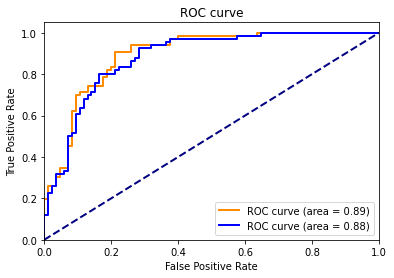

16.35638566

In [14]:
lr.auc(label_l, prepro_l)